In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

In [3]:
df = pd.concat([train,test])
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
display(train)
display(train.describe().T)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250


,count,mean,std,min,25%,50%,75%,max
LAT,86584.0,45.421456,0.225409,44.924694,45.249544,45.478996,45.601232,45.889734
LON,86584.0,10.014272,1.056637,8.736497,9.195325,9.611738,10.683357,12.590682
Precipitation,86584.0,2.585528,7.617394,0.000000,0.000000,0.000000,0.000000,135.396805
LST,46798.0,299.268841,10.927167,253.200000,290.920000,300.760000,307.940000,327.840000
AAI,73709.0,-1.274999,0.693003,-5.196266,-1.749425,-1.349746,-0.878857,2.143020
CloudFraction,73709.0,0.200606,0.259607,0.000000,0.023900,0.078478,0.278451,1.000000
NO2_strat,73709.0,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000073
NO2_total,73709.0,0.000156,0.000103,-0.000012,0.000100,0.000122,0.000173,0.002047
NO2_trop,51111.0,0.000105,0.000092,-0.000025,0.000047,0.000071,0.000129,0.001097
TropopausePressure,73709.0,16655.112392,3000.748790,8614.349685,14432.114060,16711.190570,19252.648570,24449.007150


In [5]:
display(test)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,ID_2MYNQS,1/1/19,PD03,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819
1,ID_P4U5WU,1/1/19,TV03,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790
2,ID_U4KWPK,1/1/19,X5561,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,ID_QGSNTZ,1/1/19,X5953,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006
4,ID_GHSZ6K,1/1/19,X6701,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,ID_GUSXU9,12/31/21,TV03,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860
6572,ID_GMVEG1,12/31/21,X5561,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764
6573,ID_GD6HNP,12/31/21,X5953,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6574,ID_J7YW1Y,12/31/21,X6701,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260


In [6]:
sample_submission.head()

,ID_Zindi,GT_NO2
0,ID_003WOR,0
1,ID_009Y2B,0
2,ID_01C05M,0
3,ID_0216G3,0
4,ID_023C6G,0


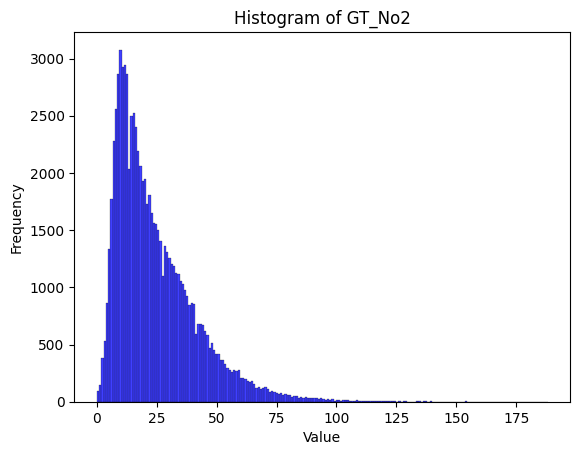

In [7]:
sns.histplot(train["GT_NO2"], bins=202, kde=False, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of GT_No2')

# Display the plot
plt.show()

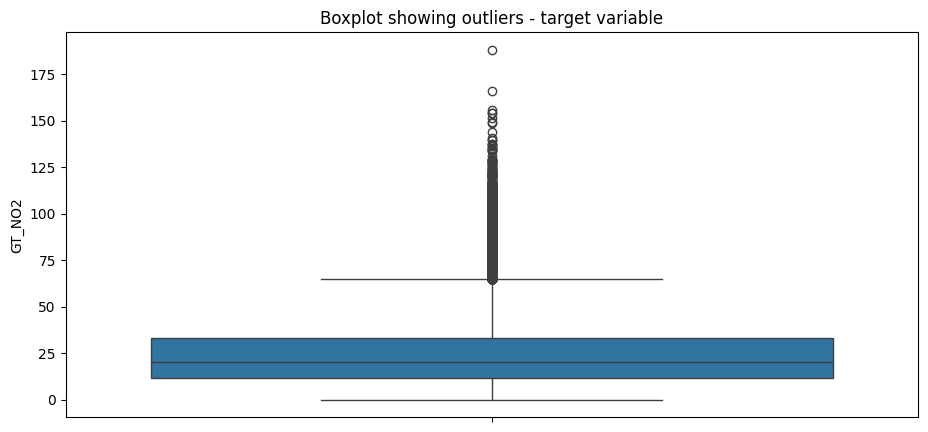

In [8]:
plt.figure(figsize = (11, 5))
sns.boxplot(train.GT_NO2)
plt.title('Boxplot showing outliers - target variable')
plt.show()

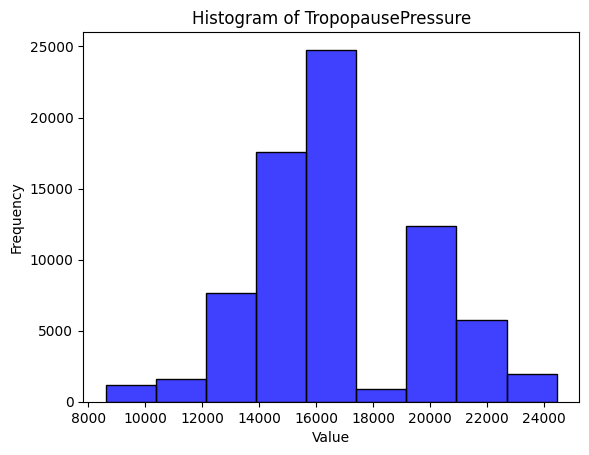

In [9]:
sns.histplot(train["TropopausePressure"], bins=9, kde=False, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of TropopausePressure')

# Display the plot
plt.show()

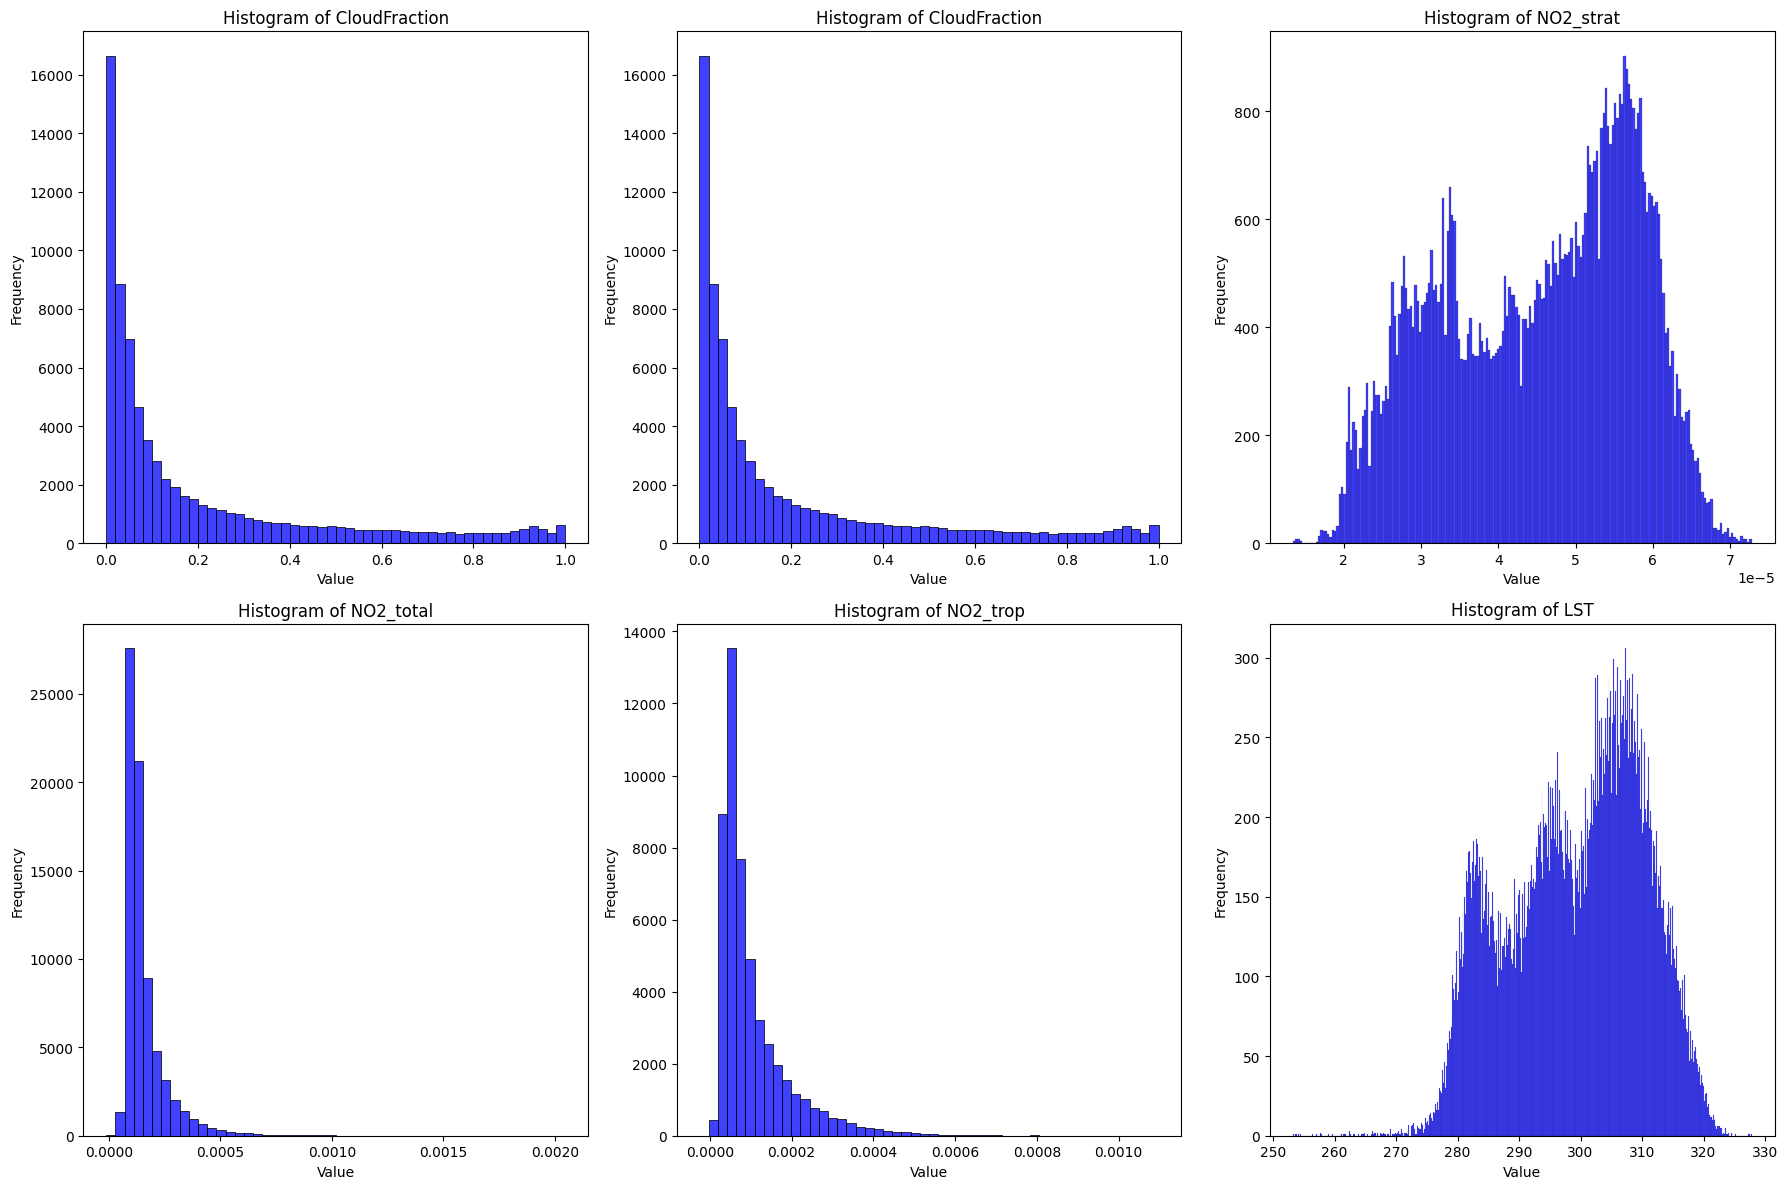

In [10]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot the first histogram in the first subplot
sns.histplot(train["CloudFraction"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[0, 0])
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of CloudFraction')

# Plot the second histogram in the second subplot
sns.histplot(train["CloudFraction"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[0, 1])
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of CloudFraction')

# Plot the third histogram in the third subplot
sns.histplot(train["NO2_strat"], bins=200, kde=False, color='blue', edgecolor='black', ax=axes[0, 2])
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Histogram of NO2_strat')

# Plot the fourth histogram in the fourth subplot
sns.histplot(train["NO2_total"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of NO2_total')

# Plot the fifth histogram in the fifth subplot
sns.histplot(train["NO2_trop"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[1, 1])
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of NO2_trop')

# Plot the sixth histogram in the sixth subplot
sns.histplot(train["LST"], bins=500, kde=False, color='blue', edgecolor='black', ax=axes[1, 2])
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Histogram of LST')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

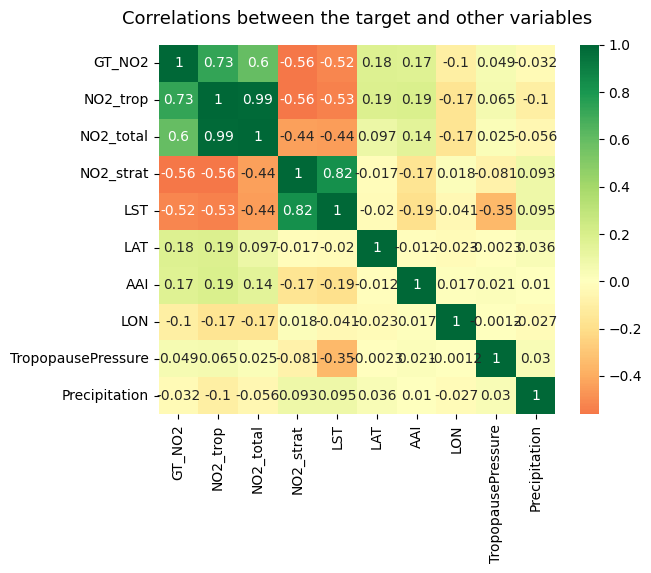

In [11]:
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['GT_NO2']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [12]:
X = train_num_df.drop('GT_NO2', axis = 1)
y = train.GT_NO2

test_df = test[X.columns]
test_df.head()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819
1,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006
4,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840


In [13]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    score = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)
    return score.mean()*-1

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-10-14 11:50:23,894] A new study created in memory with name: no-name-20145b12-62c7-42da-b337-e0a609af2c7a
[W 2024-10-14 11:50:32,711] Trial 0 failed with parameters: {'lambda_l1': 0.00010387983506156274, 'lambda_l2': 0.009507718740559641, 'num_leaves': 81, 'feature_fraction': 0.767414079624715, 'bagging_fraction': 0.7009172653411493, 'bagging_freq': 5, 'min_child_samples': 70} because of the following error: The value nan is not acceptable.
[W 2024-10-14 11:50:32,715] Trial 0 failed with value nan.
[W 2024-10-14 11:50:43,836] Trial 1 failed with parameters: {'lambda_l1': 3.2542149479555493, 'lambda_l2': 1.0011963087943536e-06, 'num_leaves': 212, 'feature_fraction': 0.7453659882399759, 'bagging_fraction': 0.5105603324254661, 'bagging_freq': 1, 'min_child_samples': 70} because of the following error: The value nan is not acceptable.
[W 2024-10-14 11:50:43,841] Trial 1 failed with value nan.
[W 2024-10-14 11:50:49,647] Trial 2 failed with parameters: {'lambda_l1': 5.57255290007936

KeyboardInterrupt: 

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

params=study.best_params

model = LGBMRegressor(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

In [ ]:
preds = model.predict(test_df)

sub = pd.DataFrame({'id': test['id'], 'GT_NO2': preds})

sub

In [ ]:
sub.to_csv('submission.csv', index = False)